In [90]:
import numpy as np
from matplotlib.patches import Circle as PlotCircle
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
from Circle import Circle
from Vertex import Vertex
from geometry import intersection, closest_pair, closest_non_intersecting


def average(x):
    sx = 0.0
    sy = 0.0
    c = 0
    for u in x:
        sx += u[0]
        sy += u[1]
        c += 1
    return sx/c, sy/c

In [98]:
def estimate(o_):
    r = [] # tablica pomocnicza
    res = [] # tablica wynikowa
    o = list(o_) # będziemy porównywać kolejne pary okręgów, dlatego dla wygody
    o.append(o[0]) # warto, żeby pierwszy element był też ostatnim
    for i in range(0, len(o) - 1): # dla każdej pary sąsiednich okręgów
        o1 = o[i]
        o2 = o[i + 1]
        p1, p2 = intersection(o1, o2) # wyznacz ich punkty przecięcia
        if p1 is not None: # funkcja wyznaczająca przecięcia jest zbudowana tak, że zwraca None wtw. okręgi się nie przecinają
            r.append((p1, p2)) # jeśli okręgi się przecinają, zapamiętaj oba punkty
        else:
            p1, p2 = closest_non_intersecting(o1, o2) # jeśli okręgi nie przecinają się, wyznacz najbliższe dwa punkty na okręgach
            res.append(average([p1, p2])) # zapamiętaj ich średnią po każdej współrzędnej

    r_flat = [p for pair in r for p in pair]
    yield r_flat # #1 - przecięcia par okręgów
    r.append(r[0])
    for i in range(0, int(len(o_)/2)): # teraz robimy to samo dla przeciwległych okręgów
        o1 = o[i]
        o2 = o[i + int(len(o_)/2)]
        p1, p2 = intersection(o1, o2)
        if p1 is not None:
            r.append((p1, p2))
        else:
            p1, p2 = closest_non_intersecting(o1, o2)
            res.append(average([p1, p2]))
            
    for i in range(0, len(r) - 1): # wybieramy najbliższe pary z przecięć każdych sąsiednich okręgów
        aux = [r[i][0], r[i][1], r[i + 1][0], r[i + 1][1]]
        p1, p2 = closest_pair(aux)
        if p1 is not None and p2 is not None:
            res.append(average([p1, p2])) # zapamiętujemy ich średnią po każdej współrzędnej
    yield res # #2 wyniki
    yield average(res) # #3 - ostateczny wynik - punkt

In [99]:
# wczytaj anchory
anchors_raw = np.genfromtxt('anchors.csv', delimiter=',', dtype=float, missing_values=0, skip_header=1)
anchors = [(x[1], x[2]) for x in anchors_raw]

python_data = np.genfromtxt('python_points_data.csv', delimiter=',', dtype=float, missing_values=0, skip_header=1)
cpp_data = np.genfromtxt('cpp_points_data.csv', delimiter=',', dtype=float, missing_values=0, skip_header=1)
tags = []

# wczytaj tagi z C++
tags_cpp = []
for row in cpp_data:
    tags_cpp.append(Vertex(int(row[0]), (row[1], row[2])))

In [100]:
fig, ax = plt.subplots(figsize = (15,12))
patches = []

np.random.seed(19680805)
sample_point = np.random.randint(0, len(python_data)-1) # wybieramy losowy zestaw pomiarów

measurements = python_data[sample_point][1:] # skip tag_id
tag_id = python_data[sample_point][0]

print(measurements)

# każdy anchor tworzy okrąg o środku w punkcie zaczepienia i promieniu równym odległości od punktu
circles = [Circle(anchors[i], measurements[i]) for i in range(0, len(measurements))]

for i in range(0, len(measurements)):
    c = PlotCircle(anchors[i], measurements[i]) # tworzymy patch Circle do wykresu
    patches.append(c)

# generator zwracający zestawy punktów na kolejnych etapach przybliżania
estimation = estimate(circles)
intersections = next(estimation)
closest_points = next(estimation)
final_point = next(estimation)

[ 1.9019228   2.35615794  1.38459036  0.62015382]


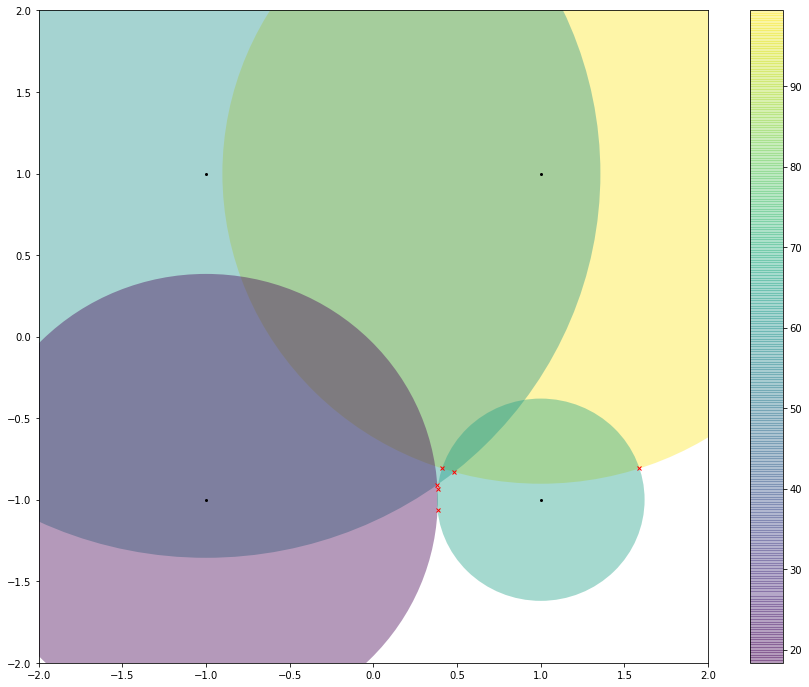

In [103]:
fig, ax = plt.subplots(figsize = (15,12))
p = PatchCollection(patches, alpha=0.4)
p.set_array(np.array(colors))
ax.add_collection(p)
fig.colorbar(p, ax=ax)
ax.set_ylim([-2, 2])
ax.set_xlim([-2, 2])
for a in anchors:
    plt.plot([a[0]], [a[1]], label='aa', marker='o', markersize=2, color="black")

# punkty przecięcia
for point in intersections:
    plt.plot(point[0], point[1], marker='x', markersize=4, color="red")

plt.show()

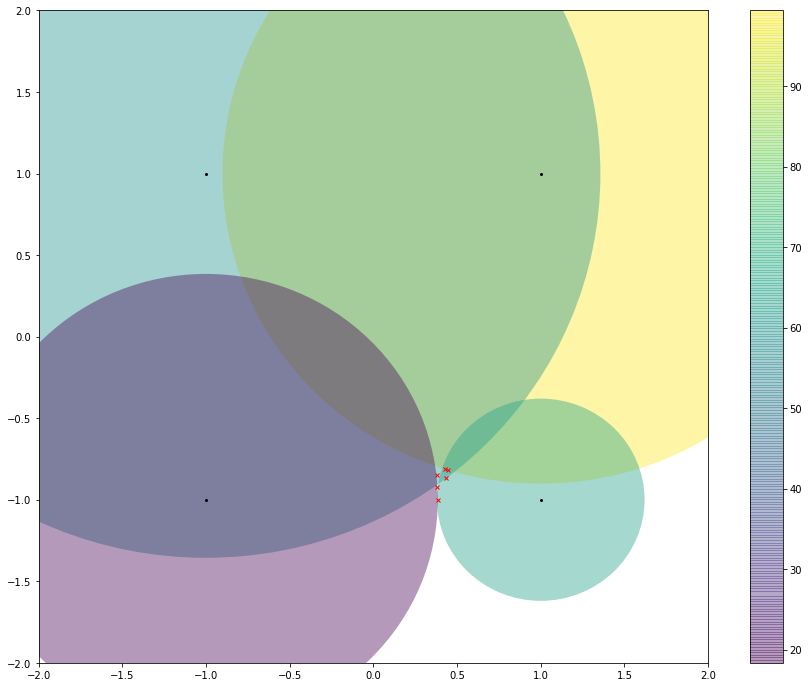

In [102]:
fig, ax = plt.subplots(figsize = (15,12))
p = PatchCollection(patches, alpha=0.4)
p.set_array(np.array(colors))
ax.add_collection(p)
fig.colorbar(p, ax=ax)
ax.set_ylim([-2, 2])
ax.set_xlim([-2, 2])
for a in anchors:
    plt.plot([a[0]], [a[1]], label='aa', marker='o', markersize=2, color="black")

# punkty wybrane do średniej
for point in closest_points:
    plt.plot(point[0], point[1], marker='x', markersize=4, color="red")

plt.show()

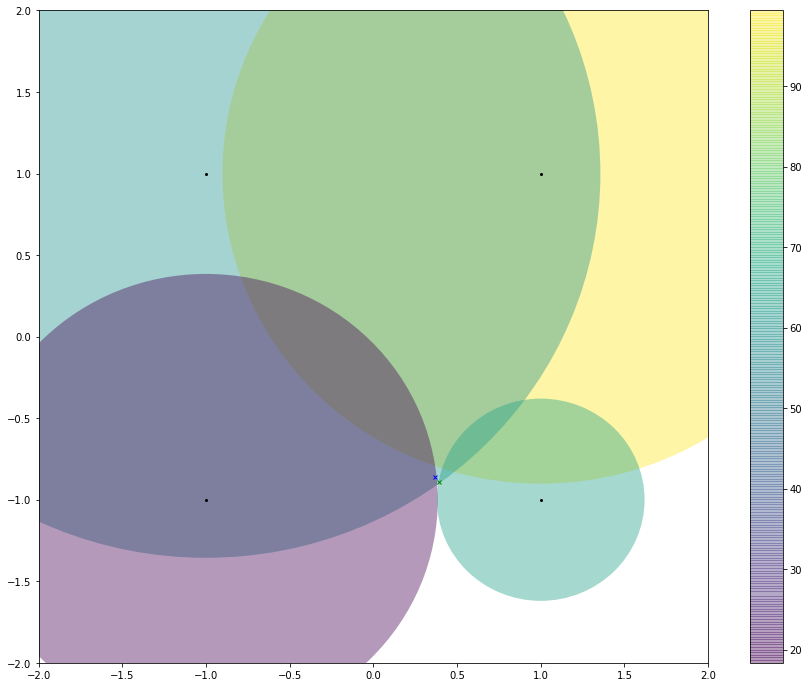

In [96]:
fig, ax = plt.subplots(figsize = (15,12))
p = PatchCollection(patches, alpha=0.4)
p.set_array(np.array(colors))
ax.add_collection(p)
fig.colorbar(p, ax=ax)
ax.set_ylim([-2, 2])
ax.set_xlim([-2, 2])
for a in anchors:
    plt.plot([a[0]], [a[1]], label='aa', marker='o', markersize=2, color="black")

# ostateczny wynik
plt.plot(final_point[0], final_point[1], marker='x', markersize=4, color="green")

# wzór z danych dla C++ dla porównania
plt.plot([tags_cpp[sample_point].p[0]], [tags_cpp[sample_point].p[1]], marker='x', markersize=4, color="blue")

plt.show()